In [757]:
import numpy as np
from typing import Tuple, Callable
import time
import matplotlib.pyplot as plt
import pandas as pd

In [758]:
# Dữ liệu đầu vào
A = np.array([[1, 2],
              [-1, 3],
              [0.5, -2]])
b = np.array([0.1, 0.2, -0.1])

# x0 = np.random.uniform(low=-10.0, high=5.0, size=2)
x_init = np.array([0.0, 0.0])

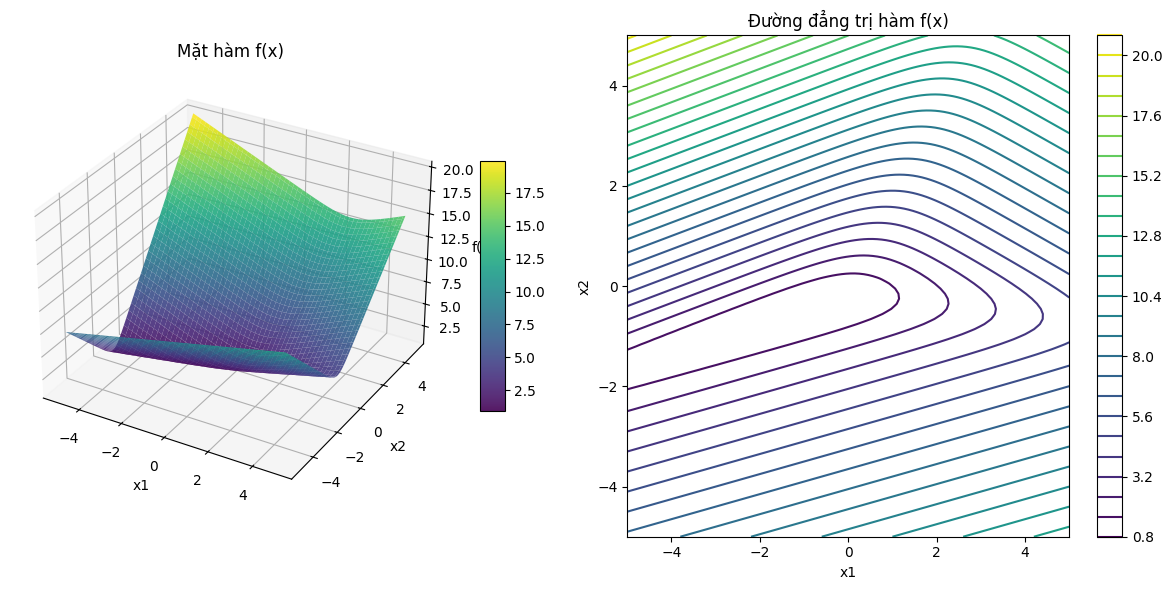

In [759]:
# Cài đặt hàm f(x) đề bài yêu cầu và gradient của hàm f(x)
def f(x: np.ndarray) -> float:
    return np.log(np.sum(np.exp(A @ x + b)))

def grad_f(x: np.ndarray) -> np.ndarray:
    exps = np.exp(A @ x + b)
    return (exps @ A) / np.sum(exps)

def phi_k(t, xk, dk):
    return f(xk - t * dk)

x1 = np.linspace(-5, 5, 100)
x2 = np.linspace(-5, 5, 100)
X1, X2 = np.meshgrid(x1, x2)

Z = np.zeros_like(X1)
for i in range(X1.shape[0]):
    for j in range(X1.shape[1]):
        x = np.array([X1[i, j], X2[i, j]])
        Z[i, j] = f(x)

# Vẽ 2 biểu đồ song song
fig = plt.figure(figsize=(12, 6))

# Bên trái: phác họa đồ thị f(x)
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
surf = ax1.plot_surface(X1, X2, Z, cmap='viridis', edgecolor='none', alpha=0.9)
ax1.set_title('Mặt hàm f(x)')
ax1.set_xlabel('x1')
ax1.set_ylabel('x2')
ax1.set_zlabel('f(x)')
fig.colorbar(surf, ax=ax1, shrink=0.5, aspect=10)

# Bên phải: các đường đẳng trị
ax2 = fig.add_subplot(1, 2, 2)
cont = ax2.contour(X1, X2, Z, levels=30, cmap='viridis')
ax2.set_title('Đường đẳng trị hàm f(x)')
ax2.set_xlabel('x1')
ax2.set_ylabel('x2')
fig.colorbar(cont, ax=ax2)

plt.tight_layout()
plt.show()

# Phương pháp Parabol

In [760]:
def parabolic_interpolation_step(x1: float, x2: float, x3: float, f1: float, f2: float, f3: float) -> float:
    num = (x2 - x1) * 2 * (f2 - f3) - (x2 - x3) * 2 * (f2 - f1)
    den = (x2 - x1) * (f2 - f3) - (x2 - x3) * (f2 - f1)

    if abs(den) < 1e-12:
        return 0.5 * (x1 + x3)
    
    x_min = x2 - 0.5 * num / den

    if x_min < x1:
        return x1
    if x_min > x3:
        return x3
    return x_min

def parabol_line_search(phi: Callable, a: float = 0.0, b: float = 1.0, c: float = 2.0, tol: float = 1e-5, max_iter: int = 100) -> Tuple[float, int]:
    x1, x2, x3 = sorted([a, b, c])
    f1 = phi(x1); f2 = phi(x2); f3 = phi(x3)
    function_calls = 3
    
    for k in range(max_iter):
        x_new = parabolic_interpolation_step(x1, x2, x3, f1, f2, f3)
        f_new = phi(x_new)
        function_calls += 1

        if abs(x2 - x_new) < tol:
            return x_new, function_calls

        if x_new < x2:
            if f_new < f2:
                x3, f3 = x2, f2
                x2, f2 = x_new, f_new
            else:
                x1, f1 = x_new, f_new
        else:
            if f_new < f2:
                x1, f1 = x2, f2
                x2, f2 = x_new, f_new
            else:
                x3, f3 = x_new, f_new
    
    return x2, function_calls

# Phương pháp Brent

In [761]:
def brent_line_search(phi: Callable, a: float = 0.0, b: float = 1.0, tol: float = 2.0, max_iter: int = 100) -> Tuple[float, int]:
    function_calls = 0
    golden_ratio = (3 - np.sqrt(5)) / 2

    x = w = v = a + golden_ratio * (b - a)
    fx = fw = fv = phi(x)
    function_calls += 1

    d = e = 0.0

    for k in range(max_iter):
        xm = 0.5 * (a + b)
        tol1 = tol * abs(x) + 1e-10
        tol2 = 2.0 * tol1

        if abs(x - xm) <= (tol2 - 0.5 * (b - a)):
            return x, function_calls
        
        if abs(e) > tol1:
            r = (x - w) * (fx - fv)
            q = (x - v) * (fx - fw)
            p = (x - v) * q - (x - w) * r
            q = 2.0 * (q - r)

            if q > 0:
                p = -p
            q = abs(q)

            etemp = e
            e = d

            # Kiem tra co chap nhan buoc parabol khong
            parabolic_ok = (abs(p) < abs(0.5 * q * etemp) and p > q * (a - x) and p < q * (b - x))

            if parabolic_ok:
                # Sử dụng bước nội suy parabol
                d = p / q
                u = x + d

                if (u - a) < tol2 or (b - u) < tol2:
                    d = tol1 if xm - x >= 0 else -tol1
            else:
                e = (a - x) if x >= xm else (b - x)
                d = golden_ratio * e
        else:
            e = (a - x) if x >= xm else (b - x)
            d = golden_ratio * e
        
        # Tinh diem moi
        if abs(d) >= tol1:
            u = x + d
        else:
            u = x + (tol1 if d >= 0 else -tol1)
        
        fu = phi(u)
        function_calls += 1

        if fu <= fx:
            if u >= x:
                a = x
            else:
                b = x

            v, w, x = w, x, u
            fv, fw, fx = fw, fx, fu
        else:
            if u < x:
                a = u
            else:
                b = u

            if fu <= fw or w == x:
                v, w = w, u
                fv, fw = fw, fu
            elif fu <= fv or v == x or v == w:
                v = u
                fv = fu
    return x, function_calls

# Thuật toán Gradient Descent

In [762]:
def gradient_descent(method: str, x0: np.ndarray, tol: float = 1e-5, max_iter: int = 1000):
    x = np.array(x0, dtype=float)
    k = 0
    total_calls = 0
    converged = False

    history = {
        'iterations': [],
        'fvals': [],
        'grad_norms': [],
        'func_calls': []
    }

    while k < max_iter:
        g = grad_f(x)  # Gradient tại x_k
        grad_norm = np.linalg.norm(g)
        fval = f(x)

        # luu du lieu vong lap hien tai
        history['iterations'].append(k)
        history['fvals'].append(fval)
        history['grad_norms'].append(grad_norm)
        history['func_calls'].append(total_calls)

        if grad_norm < tol:
            converged = True
            break

        def phi(t):
            return f(x - t * g)

        # Tìm t_k
        if method == "parabolic":
            t, calls = parabol_line_search(phi, tol=1e-5)
        elif method == "brent":
            t, calls = brent_line_search(phi, tol=1e-5)
        else:
            raise ValueError("Unknown method. Use 'parabolic' or 'brent'.")

        total_calls += calls
        # print(f"Vòng lặp {k:2d}: t_{k} = {t:.6f}, f(x_{k}) = {f(x):.6f}, ||∇f|| = {grad_norm:.5f}")
        x = x - t * g  # Cập nhật x_{k+1}
        k += 1
    return x, k, total_calls, converged, history

print("Phương pháp Parabol")
x_parabolic, iters_parabolic, calls_parabolic, converged_parabolic, history_parabol = gradient_descent("parabolic", x_init)
print(f"Nghiệm xấp xỉ: {x_parabolic}")
print(f"Số bước di chuyển: {iters_parabolic}")
print(f"Tổng số lần gọi hàm f(x): {calls_parabolic}")
print(f"Đã hội tụ: {converged_parabolic}\n")

print("Phương pháp Brent")
x_brent, iters_brent, calls_brent, converged_brent, history_brent = gradient_descent("brent", x_init)
print(f"Nghiệm xấp xỉ: {x_brent}")
print(f"Số lần lặp: {iters_brent}")
print(f"Tổng số lần gọi hàm f(x): {calls_brent}")
print(f"Đã hội tụ: {converged_brent}")

Phương pháp Parabol
Nghiệm xấp xỉ: [-1.09050021 -0.48931551]
Số bước di chuyển: 182
Tổng số lần gọi hàm f(x): 18746
Đã hội tụ: True

Phương pháp Brent
Nghiệm xấp xỉ: [-1.09048639 -0.48931352]
Số lần lặp: 157
Tổng số lần gọi hàm f(x): 1897
Đã hội tụ: True


Lần chạy 1: 
Nghiệm hiện tại: [-1.25459881  4.50714306]
Số bước di chuyển của Parabol = 185, Số lần gọi hàm f(x) = 19055, Thời gian thực thi = 0.201158
Số bước di chuyển của Brent = 204, Số lần gọi hàm f(x) = 2565, Thời gian thực thi  0.038855
Lần chạy 2: 
Nghiệm hiện tại: [2.31993942 0.98658484]
Số bước di chuyển của Parabol = 186, Số lần gọi hàm f(x) = 19158, Thời gian thực thi = 0.192687
Số bước di chuyển của Brent = 180, Số lần gọi hàm f(x) = 2183, Thời gian thực thi  0.034591
Lần chạy 3: 
Nghiệm hiện tại: [-3.4398136 -3.4400548]
Số bước di chuyển của Parabol = 276, Số lần gọi hàm f(x) = 28428, Thời gian thực thi = 0.370864
Số bước di chuyển của Brent = 295, Số lần gọi hàm f(x) = 3092, Thời gian thực thi  0.039584
Lần chạy 4: 
Nghiệm hiện tại: [-4.41916388  3.66176146]
Số bước di chuyển của Parabol = 234, Số lần gọi hàm f(x) = 24102, Thời gian thực thi = 0.284247
Số bước di chuyển của Brent = 264, Số lần gọi hàm f(x) = 3149, Thời gian thực thi  0.038426
Lần chạy 5: 
Nghiệm hiện tại

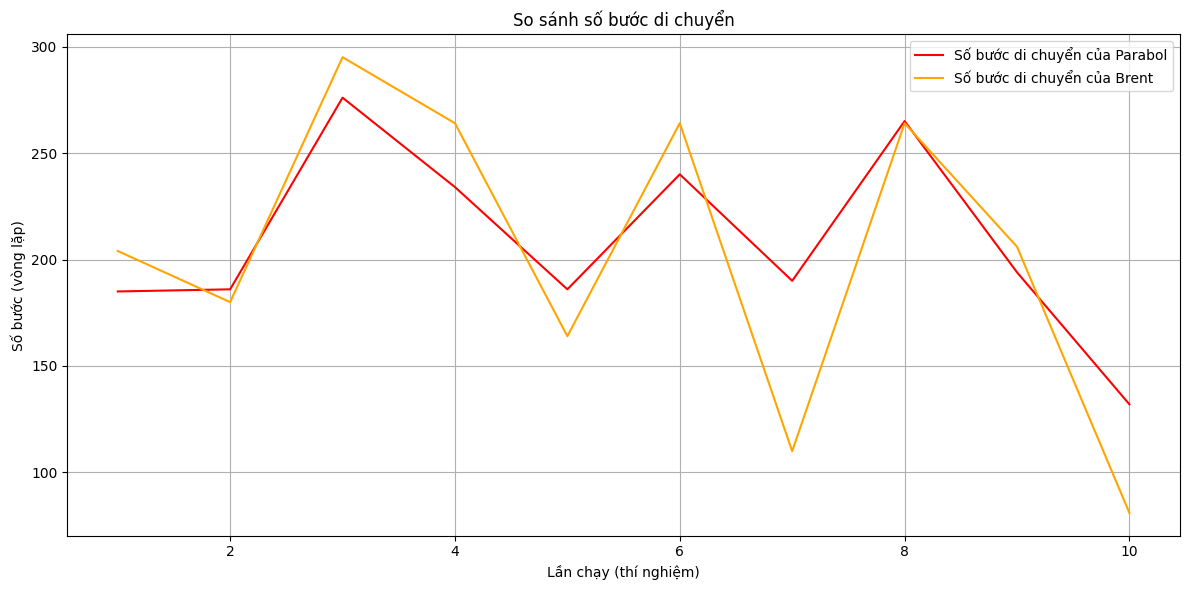

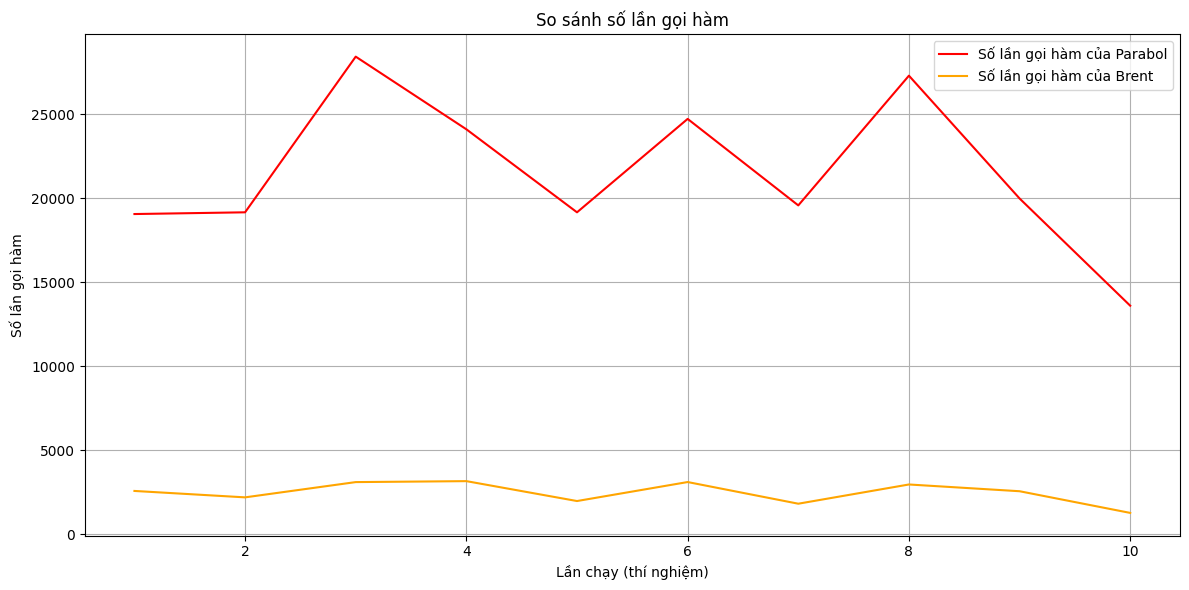

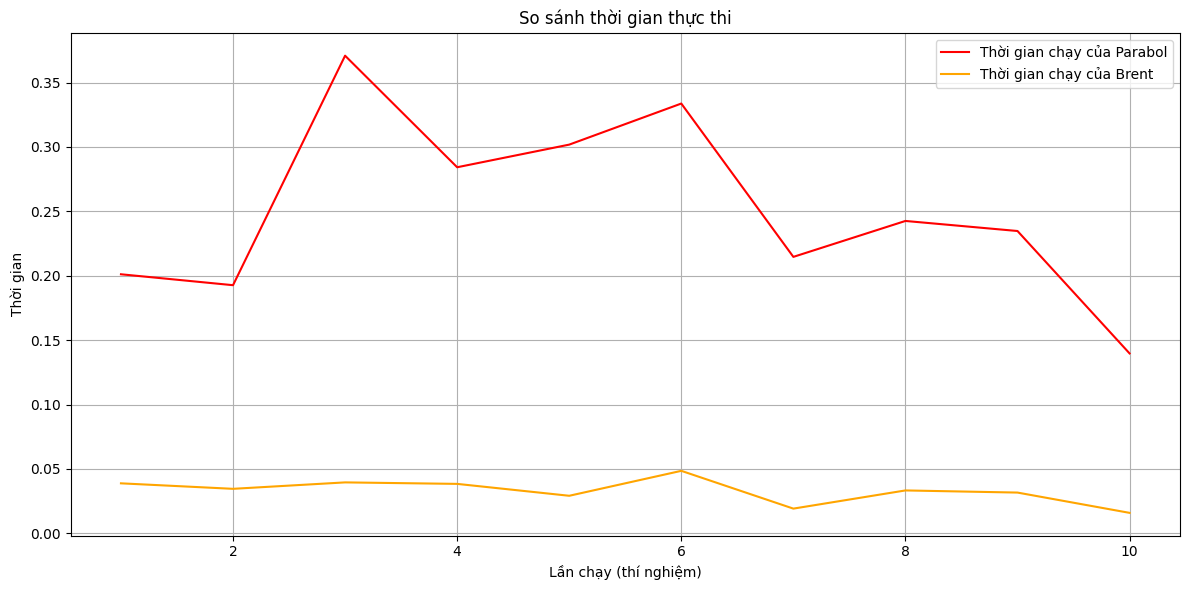

In [ ]:
def run_compare_experiments(num_runs: int = 10):
    np.random.seed(42)
    
    # Lưu lịch sử của phương pháp Parabol
    results_parabolic = {
        'steps': [],
        'calls': [],
        'times': [],
        'converged': []
    }
    # Lưu lịch sử của phương pháp Brent
    results_brent = {
        'steps': [],
        'calls': [],
        'times': [],
        'converged': []
    }
    
    for i in range(num_runs):
        x0 = np.random.uniform(-5, 5, size=2)
        print(f"Lần chạy {i+1}: ")

        print(f"Nghiệm hiện tại: {x0}")
        # Parabolic
        start_p = time.perf_counter()
        x_opt_p, n_steps_p, n_calls_p, conv_p, _ = gradient_descent("parabolic", x0)
        end_p = time.perf_counter()
        total_time_p = end_p - start_p

        results_parabolic['steps'].append(n_steps_p)
        results_parabolic['calls'].append(n_calls_p)
        results_parabolic['times'].append(total_time_p)
        results_parabolic['converged'].append(conv_p)

        # Brent
        start_brent = time.perf_counter()
        x_opt_b, n_steps_b, n_calls_b, conv_b, _ = gradient_descent("brent", x0)
        end_brent = time.perf_counter()
        total_time_brent = end_brent - start_brent

        results_brent['steps'].append(n_steps_b)
        results_brent['calls'].append(n_calls_b)
        results_brent['times'].append(total_time_brent)
        results_brent['converged'].append(conv_b)

        print(f"Số bước di chuyển của Parabol = {n_steps_p}, Số lần gọi hàm f(x) = {n_calls_p}, Thời gian thực thi = {total_time_p :.6f}")
        print(f"Số bước di chuyển của Brent = {n_steps_b}, Số lần gọi hàm f(x) = {n_calls_b}, Thời gian thực thi {total_time_brent: .6f}")

    runs = range(1, num_runs + 1)

    ratio_accepted_parabolic = sum(results_parabolic['converged']) / num_runs
    ratio_accepted_brent = sum(results_brent['converged']) / num_runs

    print(f"\nTỉ lệ hội tụ của Parabolic: {ratio_accepted_parabolic:.2%}")
    print(f"Tỉ lệ hội tụ của Brent: {ratio_accepted_brent:.2%}")

    # Biểu đồ 1: Số bước
    plt.figure(figsize=(12,6))
    plt.plot(runs, results_parabolic['steps'], label='Số bước di chuyển của Parabol', color='red')
    plt.plot(runs, results_brent['steps'], label='Số bước di chuyển của Brent', color='orange')
    plt.xlabel('Lần chạy (thí nghiệm)')
    plt.ylabel('Số bước (vòng lặp)')
    plt.title('So sánh số bước di chuyển')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Biểu đồ 2: Số lần gọi hàm
    plt.figure(figsize=(12,6))
    plt.plot(runs, results_parabolic['calls'], label='Số lần gọi hàm của Parabol', color='red')
    plt.plot(runs, results_brent['calls'], label='Số lần gọi hàm của Brent', color='orange')
    plt.xlabel('Lần chạy (thí nghiệm)')
    plt.ylabel('Số lần gọi hàm')
    plt.title('So sánh số lần gọi hàm')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Biểu đồ 3: Thời gian
    plt.figure(figsize=(12,6))
    plt.plot(runs, results_parabolic['times'], label='Thời gian chạy của Parabol', color='red')
    plt.plot(runs, results_brent['times'], label='Thời gian chạy của Brent', color='orange')
    plt.xlabel('Lần chạy (thí nghiệm)')
    plt.ylabel('Thời gian')
    plt.title('So sánh thời gian thực thi')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    df_parabolic = pd.DataFrame(results_parabolic)
    df_brent = pd.DataFrame(results_brent)

    df_parabolic['method'] = 'Parabolic'
    df_brent['method'] = 'Brent'
    df_all = pd.concat([df_parabolic, df_brent], ignore_index=True)
    df_all.to_csv('results_comparison.csv', index=False)

run_compare_experiments(num_runs=10)